# Design Brief 

An insurance company has tasked you to develop a healthcare utilization scoring model that they will be able to employ when deciding the price of insurance for individuals. The model classification task is to predict whether a person would have 'high' healthcare utilization. Consequently they want to use pricing segmentation, such that individuals with 'low' utilization will pay an X% of their salary for the insurance, while the price for those with a 'high' healthcare utilization score will be 2X% of their income. To complete the task, the company has provided you with the 2015 Consolidated Medical Expenditure data.

As in the previous use case that you have seen, I am asking you again to speak out loud while trying to explore the use-case to answer this question. You can of course use any tool that you would typically use, but you are encouraged to also make use of the toolkit I just presented to you.


# Set-up

You first need to install the required libraries for the project. The main libraries are the fairlearn and sklearn ones. We also recommend using numpy or pandas to easily manipulate and explore the data.


In [ ]:
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 7.7 MB/s 


## Load required libraries

In [ ]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes 
%matplotlib inline
# from IPython.display import Markdown, display

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV 

# Fairness metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference, equalized_odds_ratio)

from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_roc_curve)

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds, ExponentiatedGradient, TruePositiveRateParity

np.random.seed(1)

# Dataset


Load the data.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/pablobiedma/datasets/main/dataset.csv")
df.head()

,REGION,AGE,SEX,RACE,MARRY,ACTDTY,HONRDC,RTHLTH,MNHLTH,HIBPDX,...,DFSEE42,ADSMOK42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F,WEIGHT
0,2,53,1,1,5,2,2,4,3,1,...,2,2,3,0,4,1,2,1,21854.98171,65.0
1,2,56,2,1,3,2,2,4,3,1,...,2,2,17,6,4,3,2,1,18169.60482,NaN
2,2,23,2,1,5,2,2,1,1,2,...,2,2,7,0,1,2,2,0,17191.83252,NaN
3,2,3,1,1,6,3,3,1,3,-1,...,2,-1,-1,-1,-1,2,2,0,20261.48546,58.0
4,3,27,1,0,1,1,4,2,1,2,...,2,-1,-1,-1,1,3,1,0,0.00000,51.0


In [ ]:
print("Number of records: " + str(df.shape[0]))
print("Number of features: " + str(df.shape[1]))

Number of records: 4400
Number of features: 41


## Dataset description

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181).

<!-- (as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192) ). -->
 
Other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).

To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring medical care by summing up the following features: the number of office based visits, the number of outpatient visits, the number of ER visits, the number of inpatient nights, and  the number of home health visits.
After summing up all these values, the feature was made cateorical, where a sum >= 10 resulted in the value 1 (considered 'high' utilization) and a sum < 10 in the value 0. 

<!-- (High utilization respondents constitute around 17% of each dataset.) -->

|features| description|
|---|---|
| RACE, AGE, SEX, REGION, MARRY | demographic features |
| ACTDTY, HONRDC | military service (active or discharge) |
| EMPST | employment status |
| POVCAT | poverty status |
| INSCOV | health insurance coverage indicator|
| PERWT15F | person-level weight - calculated based on region, <br> status, race, sex, age & poverty status| 
| HIBPDX | blood pressure|
| CHDDX, ANGIDX, MIDX, OHRTDX | heart diseases |
| STRKDX, EMPHDX, CHBRON, CHOLDX, CANCERDX, <br> DIABDX, JTPAIN, ARTHTYPE, ASTHDX, ADHDADDX | other specific diseases (eg. diabetes, cancer, asthma etc.) |
| PREGNT | pregnant status |
| ADSMOK42 | (non)smoker |
| WLKLIM | famility walking dificulties |
| ACTLIM, SOCLIM, COGLIM | work/school, social & cognitive limitations |
| DFHEAR42, DFSEE42 | hearing & visual impairment |
| PHQ242, K6SUM42, MNHLTH, RTHLTH | mental health-related information |
| UTILIZATION | healthcare utilization|

# A1
<!-- Data skew -->

In [ ]:
print(df.skew())

NameError: ignored

# A2 
<!-- Dataset composition race -->

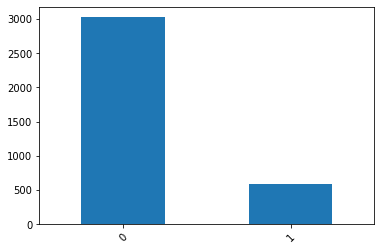

In [ ]:
df["UTILIZATION"].value_counts().plot(kind='bar', rot=45);

# A3
<!-- Dataset composition sex -->

 1    1965
 4    1237
-1    1080
 3     113
 2       5
Name: EMPST, dtype: int64


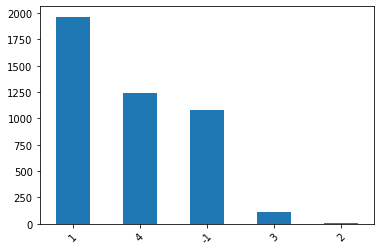

In [ ]:
print(df["EMPST"].value_counts()) # counts

df["EMPST"].value_counts().plot(kind='bar', rot=45);

# A4
<!-- Dataset composition age -->

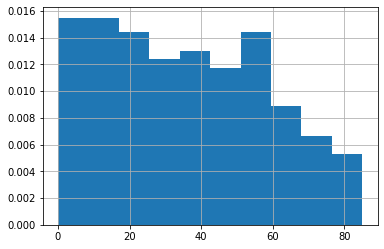

In [ ]:
df["AGE"].hist(density=1)

# A5
<!-- Label imbalance: check how many samples are labeled as positive and how many as negative -->

In [ ]:
df["UTILIZATION"].value_counts(normalize=True) # frequencies

0    0.826818
1    0.173182
Name: UTILIZATION, dtype: float64

# A6
<!-- Examine how much the label frequencies vary within each group defined by race: -->



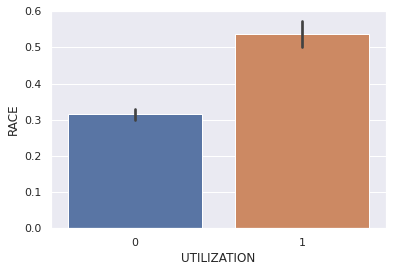

In [ ]:
import seaborn as sns
sns.set()
sns.barplot(x="UTILIZATION", y="RACE", data=df, ci=95)

# A7
<!-- Correlations between attributes -->

               REGION       AGE       SEX      RACE     MARRY    ACTDTY  \
REGION       1.000000 -0.044567  0.022588 -0.120140  0.011745 -0.011883   
AGE         -0.044567  1.000000  0.073172  0.222487 -0.707474  0.309410   
SEX          0.022588  0.073172  1.000000 -0.011451 -0.051751  0.011689   
RACE        -0.120140  0.222487 -0.011451  1.000000 -0.184606  0.117538   
MARRY        0.011745 -0.707474 -0.051751 -0.184606  1.000000  0.003535   
ACTDTY      -0.011883  0.309410  0.011689  0.117538  0.003535  1.000000   
HONRDC       0.042901 -0.728660  0.008473 -0.181948  0.598865  0.141421   
RTHLTH      -0.025198  0.344514  0.072363  0.010076 -0.216952  0.079507   
MNHLTH      -0.018612  0.216507  0.038419  0.034807 -0.116147  0.045404   
HIBPDX      -0.036585  0.596337  0.053337  0.136499 -0.575276 -0.328479   
CHDDX       -0.041104  0.700425  0.062751  0.150865 -0.636527 -0.260801   
ANGIDX      -0.041643  0.719157  0.059540  0.153599 -0.643771 -0.241980   
MIDX        -0.042945  0.

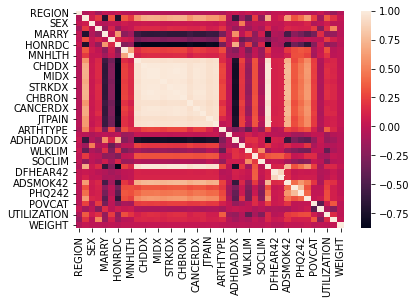

In [ ]:
import seaborn as sns
print(df.corr())

sns.heatmap(df.corr());

# A8
<!-- Missing Values -->


In [ ]:
pd_data = df
print("Number of missing values for each attribute: ", pd_data.isnull().sum())

Number of missing values for each attribute:  REGION           0
AGE              0
SEX              0
RACE             0
MARRY            0
ACTDTY           0
HONRDC           0
RTHLTH           0
MNHLTH           0
HIBPDX           0
CHDDX            0
ANGIDX           0
MIDX             0
OHRTDX           0
STRKDX           0
EMPHDX           0
CHBRON           0
CHOLDX           0
CANCERDX         0
DIABDX           0
JTPAIN           0
ARTHDX           0
ARTHTYPE         0
ASTHDX           0
ADHDADDX         0
PREGNT           0
WLKLIM           0
ACTLIM           0
SOCLIM           0
COGLIM           0
DFHEAR42         0
DFSEE42          0
ADSMOK42         0
K6SUM42          0
PHQ242           0
EMPST            0
POVCAT           0
INSCOV           0
UTILIZATION      0
PERWT15F         0
WEIGHT         790
dtype: int64


# A9
<!-- Drop any missing values that may exist. -->

In [ ]:
df = df.dropna()

In [ ]:
pd_data = df
print("Number of missing values for each attribute: ", pd_data.isnull().sum())

Number of missing values for each attribute:  REGION         0
AGE            0
SEX            0
RACE           0
MARRY          0
ACTDTY         0
HONRDC         0
RTHLTH         0
MNHLTH         0
HIBPDX         0
CHDDX          0
ANGIDX         0
MIDX           0
OHRTDX         0
STRKDX         0
EMPHDX         0
CHBRON         0
CHOLDX         0
CANCERDX       0
DIABDX         0
JTPAIN         0
ARTHDX         0
ARTHTYPE       0
ASTHDX         0
ADHDADDX       0
PREGNT         0
WLKLIM         0
ACTLIM         0
SOCLIM         0
COGLIM         0
DFHEAR42       0
DFSEE42        0
ADSMOK42       0
K6SUM42        0
PHQ242         0
EMPST          0
POVCAT         0
INSCOV         0
UTILIZATION    0
PERWT15F       0
WEIGHT         0
dtype: int64


# A10
<!-- Duplicated values -->

In [ ]:
print(df.duplicated().sum())

870


# A11
<!-- Drop any duplicates that might exist. -->

In [ ]:
df = df.drop_duplicates()

In [ ]:
print(df.duplicated().sum())

870


# A12
<!-- Outliers -->

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


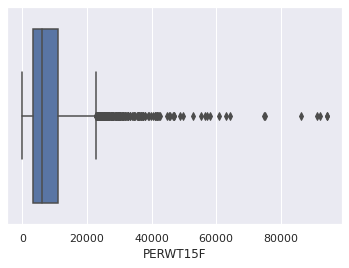

In [ ]:
# PERWT15F = person level weight (region, status, race, sex, age, poverty status)
sns.boxplot(df['PERWT15F'])

# B1 
<!-- Define target and sensitive attributes. -->

In [ ]:
# Define target and sensitive attributes.
target_variable = "UTILIZATION"
sensitive = ["RACE", "SEX"] # Or just: ["RACE"]

Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

# B2 
<!-- Mark categorical features. -->

In [ ]:
# Mark categorical features.
categorical_features=['REGION','SEX','MARRY',
                      'ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                      'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                      'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                      'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                      'PHQ242','EMPST','POVCAT','INSCOV']

df_raw = df
for col_name in categorical_features:
  df[col_name] = df[col_name].astype("category")

# B3
<!-- Drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies"). -->

In [ ]:
# Drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies").
X = pd.get_dummies(df.drop(columns=[
    "RACE",
    "SEX", 
    "UTILIZATION"
]))

# C1
<!-- Next, we split data into training and test. -->

In [ ]:
# Train-test split
random_seed = 445
np.random.seed(random_seed)

X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

ValueError: ignored

# C2
<!-- Our performance metric is balanced accuracy, so for the purposes of training (but not evaluation!) we will resample the data set, so that it has the same number of positive and negative examples. This means that we can use estimators that optimize standard accuracy (although some estimators allow the use us importance weights).

Because we are downsampling the number of negative examples, we create a training dataset with a significantly lower number of data points. For more complex machine learning models, this lower number of training data points may affect the model's accuracy. -->

In [ ]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

print("Before: " + str(X_train.shape[0]) + " records.")
print("After: " + str(X_train_bal.shape[0])+ " records.")

Before: 2200 records.
After: 762 records.


# C3
<!-- **Train the model** -->

We train a logistic regression model and save its predictions on test data for analysis.

In [ ]:
from sklearn.pipeline import Pipeline
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1] 
Y_pred = unmitigated_pipeline.predict(X_test)                  

ValueError: ignored

Check model performance on test data.

In [ ]:
# Show balanced accuracy rate of the 0/1 predictions
print(balanced_accuracy_score(Y_test, Y_pred))
print(roc_auc_score(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))

0.751705538302746
0.751705538302746
[[1171  342]
 [  79  213]]


# D1
<!-- **Fairness assessment** -->

Evaluate fairness rates.

In [ ]:
metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "true_negative_rate": true_negative_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

In [ ]:
# For SEX attribute
metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['SEX'])

# The disaggregated metrics are then stored in a pandas DataFrame:
metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,true_negative_rate,false_positive_rate,true_positive_rate,balanced_accuracy
SEX,,,,,,
1,0.274564,0.272109,0.796178,0.203822,0.727891,0.762035
2,0.357542,0.268966,0.737303,0.262697,0.731034,0.734169


In [ ]:
# For RACE attribute
metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['RACE'])

# The disaggregated metrics are then stored in a pandas DataFrame:
metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,true_negative_rate,false_positive_rate,true_positive_rate,balanced_accuracy
RACE,,,,,,
0,0.262542,0.319728,0.795996,0.204004,0.680272,0.738134
1,0.395731,0.22069,0.724138,0.275862,0.77931,0.751724


Evaluate fairness metrics (based on previously computed rates).

In [ ]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),  
        "------": (lambda x: "", True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds ratio": (
            lambda x: equalized_odds_ratio(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
#        "AUC difference": (
#            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
    }

    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

# Metrics
models_dict = {"Unmitigated": (Y_pred, Y_pred_proba)}
get_metrics_df(models_dict, Y_test, A_test) # both RACE and SEX

,Unmitigated
Demographic parity difference,0.215187
Demographic parity ratio,0.509971
------,
False positive rate difference,0.122768
False negative rate difference,0.111408
Equalized odds difference,0.122768
Equalized odds ratio,0.589103
------,
Overall AUC,0.824351
Overall balanced error rate,0.248294


# D2 
<!-- **Postprocessing with ThresholdOptimizer** -->

In [ ]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator
# The constraint false negative rate parity requires that all the groups have equal values of false negative rate.

postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In [ ]:
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)
# Record and evaluate the output of the trained ThresholdOptimizer on test data

Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)

# D3
<!-- Evaluate fairness rates (comparison between unmitigated & postprocessing). -->

Evaluate fairness rates (comparison between unmitigated & postprocessing).

In [ ]:
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=df_test['RACE'] # df_test['SEX'] 
)

pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=0)

selection_rate false_negative_rate true_negative_rate  \
                   RACE                                                         
Unmitigated        0          0.262542            0.319728           0.795996   
                   1          0.395731             0.22069           0.724138   
ThresholdOptimizer 0          0.337793            0.251701           0.719733   
                   1          0.387521            0.248276           0.726293   

                        false_positive_rate true_positive_rate  \
                   RACE                                          
Unmitigated        0               0.204004           0.680272   
                   1               0.275862            0.77931   
ThresholdOptimizer 0               0.280267           0.748299   
                   1               0.273707           0.751724   

                        balanced_accuracy  
                   RACE                    
Unmitigated        0             0.738134  
                   1             0.751724  
ThresholdOptimizer 0             0.734016  
                   1             0.739009

Evaluate fairness metrics (based on previously computed rates).

In [ ]:
models_dict = {"Unmitigated": (Y_pred, Y_pred_proba),
              "ThresholdOptimizer": (Y_pred_postprocess, Y_pred_postprocess)}
get_metrics_df(models_dict, Y_test, A_test)

,Unmitigated,ThresholdOptimizer
Demographic parity difference,0.273567,0.137472
Demographic parity ratio,0.424888,0.631415
------,,
False positive rate difference,0.175969,0.104843
False negative rate difference,0.161458,0.084821
Equalized odds difference,0.175969,0.104843
Equalized odds ratio,0.460812,0.631523
------,,
Overall AUC,0.831299,0.762969
AUC difference,0.033483,0.031227


# D4
<!-- **Reductions approach with Exponentiated Gradient** -->

**Reductions approach with Exponentiated Gradient**

The constraints supported by ExponentiatedGradient are more general than those supported by ThresholdOptimizer. For example, rather than requiring that false negative rates be equal, it is possible to specify the maxium allowed difference or ratio between the largest and the smallest value.

In [ ]:
expgrad_est = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000, random_state=random_seed),
    constraints=TruePositiveRateParity(difference_bound=0.02) #EqualizedOdds()
)

The constraints above are expressed for the true positive parity, they require that the difference between the largest and the smallest true positive rate (TPR) across all groups be at most 0.02. Since false negative rate (FNR) is equal to 1-TPR, this is equivalent to requiring that the difference between the largest and smallest FNR be at most 0.02.

In [ ]:
# Fit the exponentiated gradient model
expgrad_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

# Record and evaluate predictions on test data
Y_pred_reductions = expgrad_est.predict(X_test, random_state=random_seed)

/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use g

In [ ]:
metricframe_reductions_eg = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_reductions,
    sensitive_features=df_test['RACE'] # df_test['SEX']
)

pd.concat([metricframe_unmitigated.by_group,
           metricframe_reductions_eg.by_group],
           keys=['Unmitigated', 'ExponentiatedGradient'],
           axis=0)

selection_rate false_negative_rate  \
                      RACE                                      
Unmitigated           0          0.258359            0.265487   
                      1          0.440083            0.193548   
ExponentiatedGradient 0          0.277609            0.256637   
                      1          0.404959            0.169355   

                           true_negative_rate false_positive_rate  \
                      RACE                                          
Unmitigated           0              0.803204            0.196796   
                      1              0.686111            0.313889   
ExponentiatedGradient 0              0.782609            0.217391   
                      1              0.741667            0.258333   

                           true_positive_rate balanced_accuracy  
                      RACE                                       
Unmitigated           0              0.734513          0.768858  
                      1              0.806452          0.746281  
ExponentiatedGradient 0              0.743363          0.762986  
                      1              0.830645          0.786156

During the training process, the ExponentiatedGradient algorithm iteratively trains multiple inner models on a reweighted training dataset. The algorithm stores each of these predictors and then randomizes among them at deployment time.

In this section explore the performance of the individual predictors learned by the ExponentiatedGradient algorithm. First, note that since the base estimator was LogisticRegression all these predictors are different logistic regression models:

In [ ]:
predictors = expgrad_est.predictors_

# Collect predictions by all predictors and calculate balanced error
# as well as the false negative difference for all of them

sweep_preds = [clf.predict(X_test) for clf in predictors]
balanced_error_sweep = [1-balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in sweep_preds]

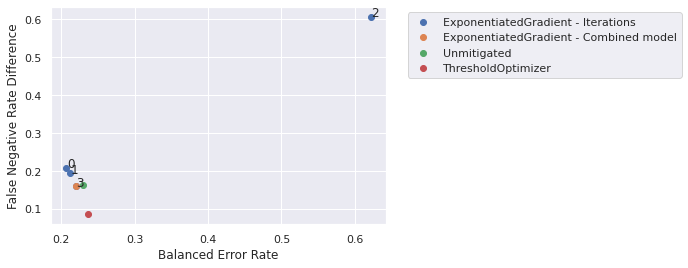

In [ ]:
# Show the balanced error / fnr difference values of all predictors on a raster plot  

plt.scatter(balanced_error_sweep, fnr_diff_sweep, label="ExponentiatedGradient - Iterations")
for i in range(len(predictors)):
  plt.annotate(str(i), xy=(balanced_error_sweep[i]+0.001, fnr_diff_sweep[i]+0.001))

# Also include in the plot the combined ExponentiatedGradient model
# as well as the 2 previously fitted models

plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_reductions),
            false_negative_rate_difference(Y_test, Y_pred_reductions, sensitive_features=A_test),
            label="ExponentiatedGradient - Combined model")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

Model performance - overall (Race)

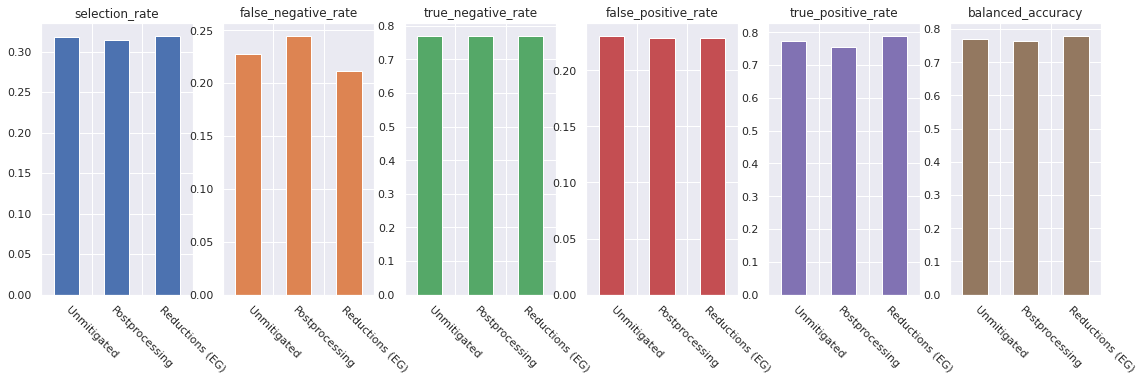

In [ ]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    "Reductions (EG)": metricframe_reductions_eg.overall
})
overall_df.transpose().plot.bar(subplots=True, layout= [1,6], figsize=(19, 5), legend=False, rot=-45, position=1.5);

# D5
<!-- **Reductions approach with Gradient Descend** -->

**Reductions approach with Gradient Descend**

In [ ]:
# Train GridSearch
sweep = GridSearch(estimator=LogisticRegression(max_iter=1000, random_state=random_seed),
                   constraints=TruePositiveRateParity(difference_bound=0.02),
                   grid_size=50,
                   grid_limit=3)

sweep.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

# Record and evaluate predictions on test data
Y_pred_reductions = sweep.predict(X_test)

/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use g

In [ ]:
metricframe_reductions_gd = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_reductions,
    sensitive_features=df_test["RACE"]
)

pd.concat([metricframe_unmitigated.by_group,
           metricframe_reductions_gd.by_group],
           keys=['Unmitigated', 'GradientDescend'],
           axis=0)

selection_rate false_negative_rate true_negative_rate  \
                RACE                                                         
Unmitigated     0          0.258359            0.265487           0.803204   
                1          0.440083            0.193548           0.686111   
GradientDescend 0          0.245187            0.274336           0.816934   
                1          0.417355            0.145161           0.733333   

                     false_positive_rate true_positive_rate balanced_accuracy  
                RACE                                                           
Unmitigated     0               0.196796           0.734513          0.768858  
                1               0.313889           0.806452          0.746281  
GradientDescend 0               0.183066           0.725664          0.771299  
                1               0.266667           0.854839          0.794086

In [ ]:
predictors = sweep.predictors_

# Collect predictions by all predictors and calculate balanced error
# as well as the false negative difference for all of them

sweep_preds = [clf.predict(X_test) for clf in predictors]
balanced_error_sweep = [1-balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in sweep_preds]

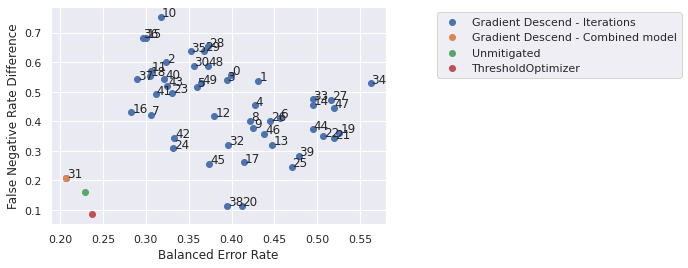

In [ ]:
# Show the balanced error / fnr difference values of all predictors on a raster plot  

plt.scatter(balanced_error_sweep, fnr_diff_sweep, label="Gradient Descend - Iterations")
for i in range(len(predictors)):
  plt.annotate(str(i), xy=(balanced_error_sweep[i]+0.001, fnr_diff_sweep[i]+0.001))

# Also include in the plot the combined ExponentiatedGradient model
# as well as the 2 previously fitted models

plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_reductions),
            false_negative_rate_difference(Y_test, Y_pred_reductions, sensitive_features=A_test),
            label="Gradient Descend - Combined model")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

Model performance overall.

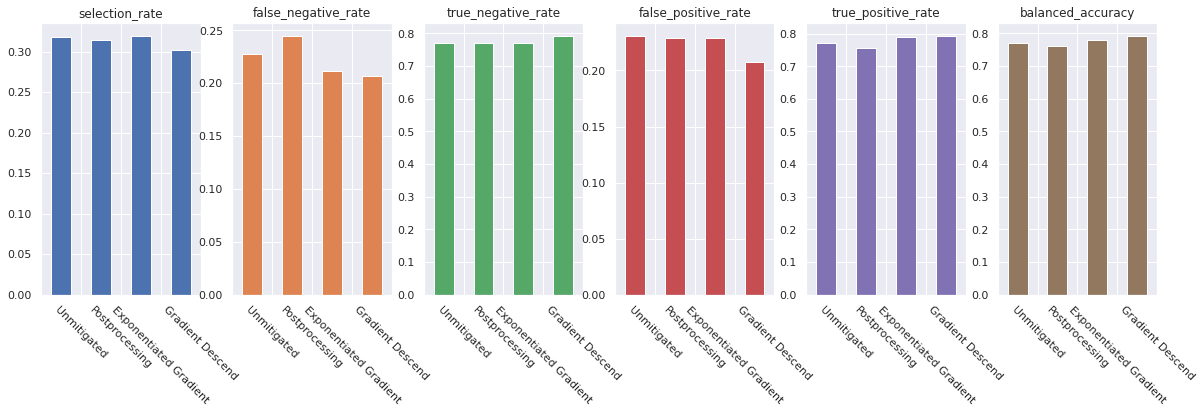

In [ ]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    "Exponentiated Gradient": metricframe_reductions_eg.overall,
    "Gradient Descend": metricframe_reductions_gd.overall
})
overall_df.transpose().plot.bar(subplots=True, layout= [1,6], figsize=(20, 5), legend=False, rot=-45, position=1.5);

# D6
<!-- **Correlation Remover** -->

**Correlation Remover**

In [ ]:
X_raw = df[["INSCOV", "PERWT15F", "AGE"]]
X_raw = pd.get_dummies(X_raw)

y = df[target_variable]

X_raw = X_raw.drop(["INSCOV_2",
                    'INSCOV_3'], axis=1)

X_raw = X_raw[["PERWT15F", "AGE", 'INSCOV_1']]

cr = CorrelationRemover(sensitive_feature_ids=["INSCOV_1"])
X_cr = cr.fit_transform(X_raw)
X_cr = pd.DataFrame(X_cr, columns=["PERWT15F", "AGE"])
X_cr["INSCOV_1"] = X_raw["INSCOV_1"]

cr_alpha = CorrelationRemover(sensitive_feature_ids=['INSCOV_1'], alpha=0.5)
X_cr_alpha = cr_alpha.fit_transform(X_raw)
X_cr_alpha = pd.DataFrame(X_cr_alpha, columns=["PERWT15F", "AGE"])
X_cr_alpha["INSCOV_1"] = X_raw["INSCOV_1"]

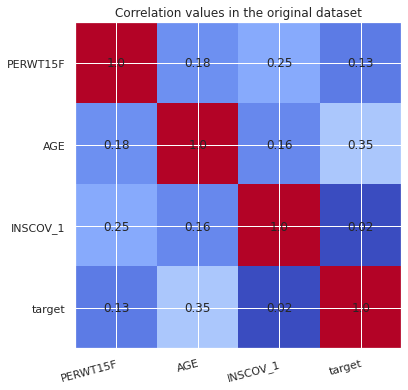

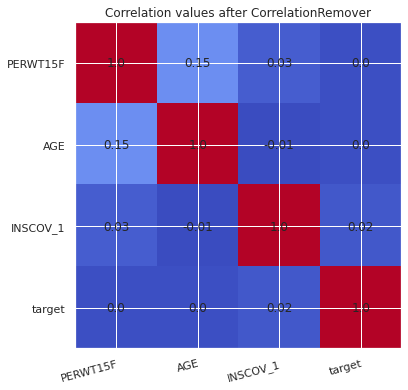

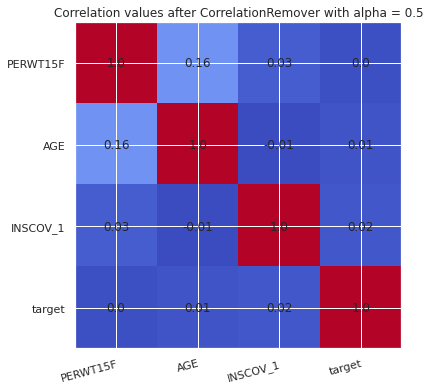

In [ ]:
def plot_heatmap(df, title):
    df['target'] = y
    cols = list(df.columns)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(round(df.corr() - 1, 2), cmap="coolwarm")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels(labels=cols)

    ax.set_yticks(np.arange(len(cols)))
    ax.set_yticklabels(labels=cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(
                j,
                i,
                round(df.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )

    ax.set_title(f"{title}")
    plt.show()


plot_heatmap(X_raw, "Correlation values in the original dataset")
plot_heatmap(X_cr, "Correlation values after CorrelationRemover")
plot_heatmap(X_cr_alpha, "Correlation values after CorrelationRemover with alpha = 0.5")